In [138]:
from pathlib import Path
import pandas as pd
import numpy as np
import warnings
import missingno as msn
import random

import matplotlib.pyplot as plt
import seaborn as sns

# Plot options
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('seaborn')
%matplotlib inline

# Clustering
import yellowbrick
from sklearn.cluster import KMeans, DBSCAN
from yellowbrick.cluster import KElbowVisualizer

# Other options
warnings.filterwarnings('ignore')

## Preprocessing

### Load data

In [2]:
%%time
df = pd.read_csv('../data/raw/Power-Networks-LCL-June2015(withAcornGps)v2.csv', parse_dates=['DateTime'])
df.head()

CPU times: user 3min 6s, sys: 7.15 s, total: 3min 13s
Wall time: 3min 42s


### Inspect data

In [3]:
df.describe()

,LCLid,stdorToU,DateTime,KWH/hh (per half hour),Acorn,Acorn_grouped
count,167932474,167932474,167932474,167932474,167932474,167932474
unique,5566,2,40405,7527,19,5
top,MAC000147,Std,2012-11-20 00:00:00,0,ACORN-E,Affluent
freq,39752,134148703,11062,2002920,48930543,67359986
first,NaN,NaN,2011-11-23 09:00:00,NaN,NaN,NaN
last,NaN,NaN,2014-02-28 00:00:00,NaN,NaN,NaN


### Drop obsolete information

In [4]:
df.drop(['Acorn', 'Acorn_grouped'], axis=1, inplace=True)
df.columns = ['LCLid', 'stdorToU', 'DateTime', 'consumption']
df.head()

,LCLid,stdorToU,DateTime,consumption
0,MAC000002,Std,2012-10-12 00:30:00,0
1,MAC000002,Std,2012-10-12 01:00:00,0
2,MAC000002,Std,2012-10-12 01:30:00,0
3,MAC000002,Std,2012-10-12 02:00:00,0
4,MAC000002,Std,2012-10-12 02:30:00,0


### Change column type

In [5]:
df['consumption'] = df['consumption'].convert_objects(convert_numeric=True)

### Missing values

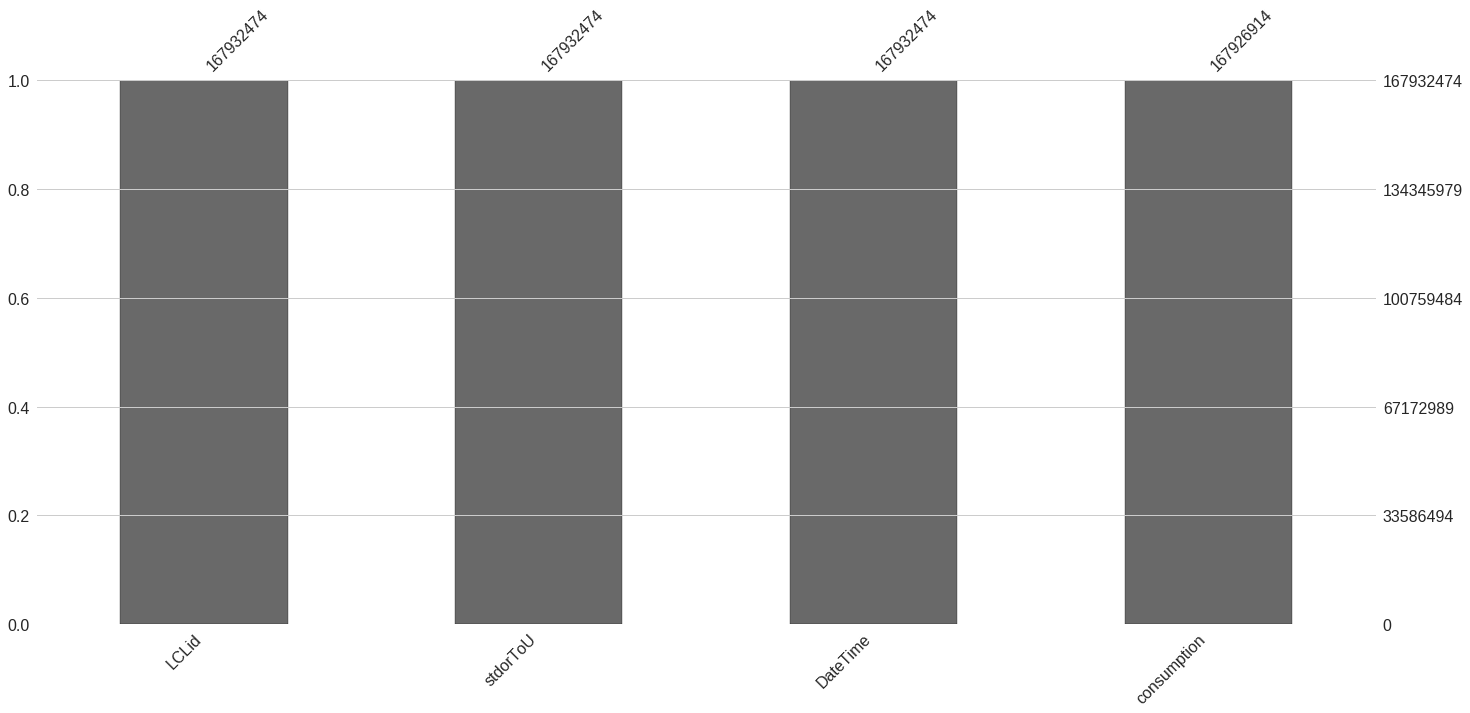

In [68]:
msn.bar(df)

## Visualizing daily load patterns

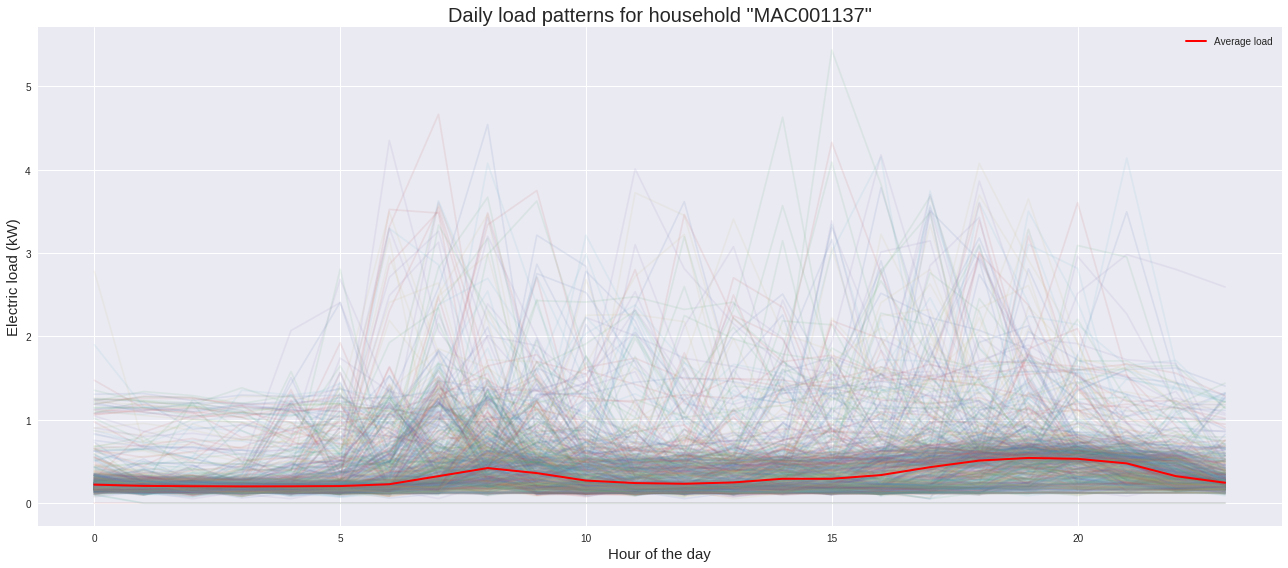

In [137]:
# Draw a random sample household
household_sample = random.choice(df.LCLid.unique())
df_sample = df[df.LCLid == household_sample]
df_sample.set_index('DateTime', inplace=True)
df_sample.drop(['LCLid', 'stdorToU'], 1, inplace=True)


# Resampling to hour
df_sample_hour = df_sample.resample('H').sum()

# Extracting necessary variables
df_sample_hour.reset_index(inplace=True)
df_sample_hour['date'] = df_sample_hour['DateTime'].apply(lambda x: x.date())
df_sample_hour['hour'] = df_sample_hour['DateTime'].apply(lambda x: x.hour)

# Long to wide for plotting
df_sample_daily_pattern = df_sample_hour.pivot_table(index='date', columns='hour', values='consumption')

# Plot
fig,ax = plt.subplots(figsize=(18,8))
ax.plot(df_sample_daily_pattern.T, alpha=0.1)
ax.plot(df_sample_daily_pattern.median(), c='red', linewidth = 2, label = 'Average load')
ax.set_xlabel('Hour of the day', size=15)
ax.set_ylabel('Electric load (kW)', size=15)
ax.set_title('Daily load patterns for household "{house}"'.format(house=household_sample), size=20)
ax.legend()
fig.tight_layout()
plt.savefig('../reports/figures/daily_patterns/' + household_sample + '.png')

## Clustering of household using hourly load patterns over the whole day

* Resampling to hour and take the sum of consumption per 30 minutes
* Calculate average load per specific hour for all households


In [12]:
household_sample = random.choices(df.LCLid.unique(), k=2000)
df_sub = df[df.LCLid.isin(household_sample)]

In [91]:
%%time

# Resampling to hour
df_sub = df_sub.groupby('LCLid').resample('H', on='DateTime').sum().reset_index()

# Extracting necessary variables
df_sub['date'] = df_sub['DateTime'].apply(lambda x: x.date())
df_sub['hour'] = df_sub['DateTime'].apply(lambda x: x.hour)

# Aggregate
df_sub_agg = df_sub.groupby(['LCLid', 'hour'])['consumption'].median().reset_index()
X = df_sub_agg.pivot_table(index='LCLid', columns='hour', values='consumption')

CPU times: user 3min 7s, sys: 4.29 s, total: 3min 11s
Wall time: 3min 11s


### K-Means clustering

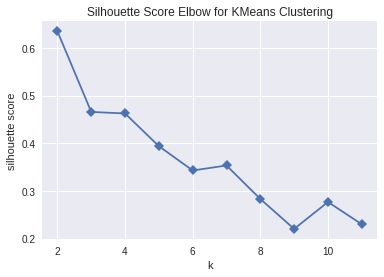

In [157]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12), timings=False, metric='silhouette')

visualizer.fit(StandardScaler().fit_transform(X))    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [158]:
yellowbrick.style.rcmod.reset_orig()

In [162]:
scaler = StandardScaler().fit(X)
kmeans = KMeans(n_clusters=2, max_iter=1000).fit(scaler.transform(X))

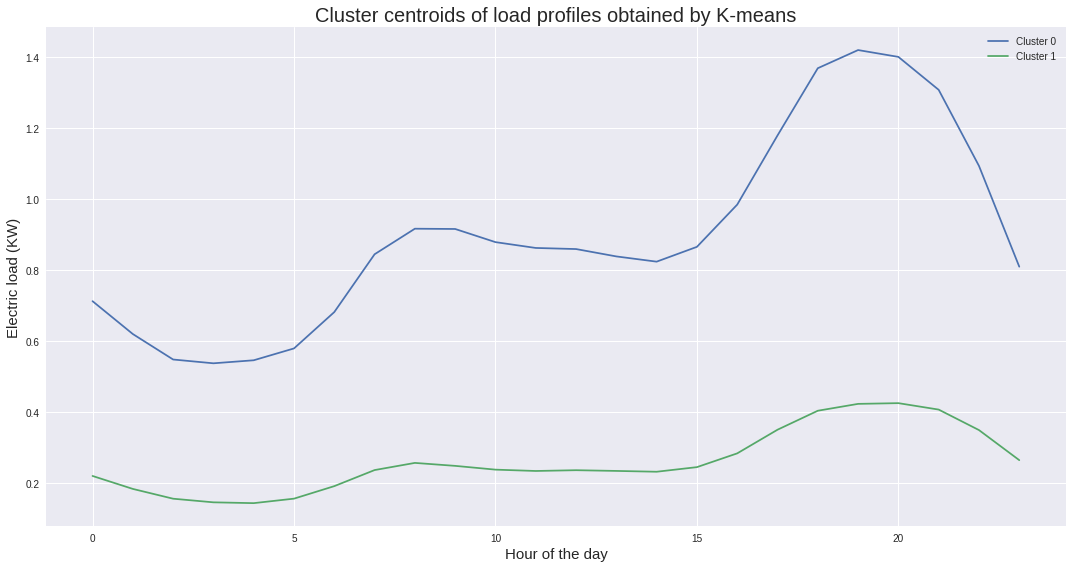

In [163]:
fig, ax = plt.subplots(figsize=(15,8))
for i in range(0,kmeans.n_clusters):
    ax.plot(np.arange(0,24), scaler.inverse_transform(kmeans.cluster_centers_[i]), label='Cluster {c}'.format(c=i))

ax.set_title('Cluster centroids of load profiles obtained by K-means', size=20)
ax.set_xlabel('Hour of the day', size=15)
ax.set_ylabel('Electric load (KW)', size=15)
ax.legend()
fig.tight_layout()

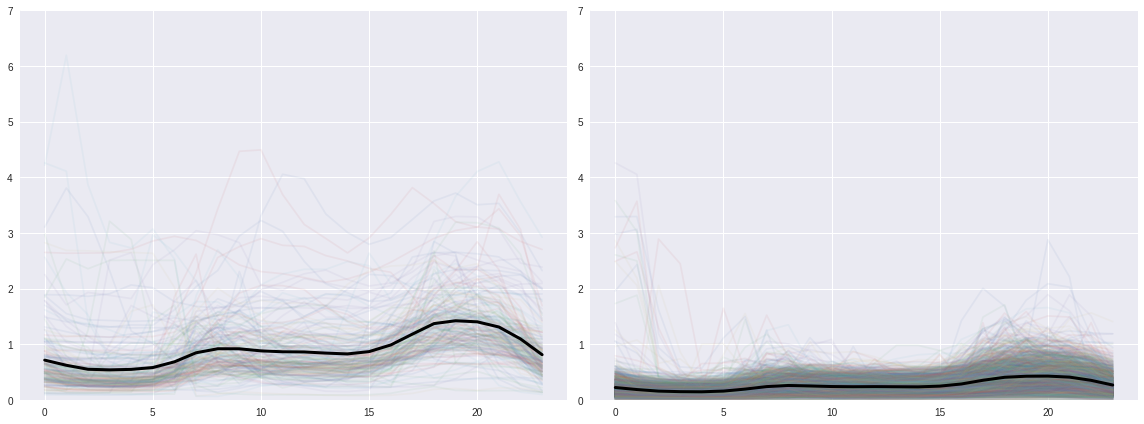

In [164]:
X_cluster= X.copy()
X_cluster['label'] = kmeans.labels_

fig, ax = plt.subplots(figsize=(8*kmeans.n_clusters,6), ncols=kmeans.n_clusters)

for c in range(0,kmeans.n_clusters):
    df_plot = X_cluster[X_cluster.label == c].drop('label', 1).T

    ax[c].plot(df_plot, alpha=0.07)
    ax[c].plot(np.arange(0,24,1), scaler.inverse_transform(kmeans.cluster_centers_[c]), linewidth=3, label='Cluster {c}'.format(c=c), color='black')
    ax[c].set_ylim(0,7)
fig.tight_layout()

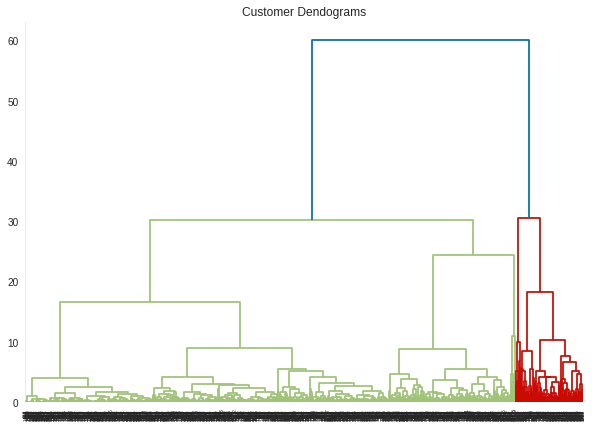

In [166]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Household loads dendograms")  
dend = shc.dendrogram(shc.linkage(X, method='ward'))  

In [167]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  
agg.fit(X)  

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=5,
            pooling_func='deprecated')

In [169]:
agg.labels_

array([1, 4, 1, ..., 4, 0, 1])